#Backtesting Demo

This is a backtesting demo for single beta and single stock.

The factor is beta from linear regression of low price on high price.

The key point is modularization. You can change the buy/sell threshold, stock, time range, factor parameters, or even the buy/sell pattern. The total amount earned and daily return duiring hold periods are shown.

The demo consists of geting data, constructing factor, calculating return, conducting multiple strategies and ploting.

The below shows the final results.

This backtesting strategy executes buy/sell orders at the opening price of the next day based on the stock's factor value, with position size being either 0 or 1. The total_earn represents the total profit/loss amount within the time range, while the strategy daily return represents the return rate based on the purchase price during the holding period.

这是一个单因子单股票的回测演示。

该因子是将低价对高价进行线性回归得到的beta。

关键点在于模块化设计。你可以修改买入/卖出阈值、股票、时间范围、因子参数，甚至买卖模式。会显示总收益和持仓期间的日收益率。

该演示包括获取数据、构建因子、计算收益、执行多种策略和绘图等模块。

以下展示了最终输出。

这个回测策略根据股票的因子数值在第二天以开盘价执行买卖订单，持仓规模为0或1。total_earn代表时间范围内的总盈亏金额，而策略日收益率代表持有期间基于买入价格的收益率。

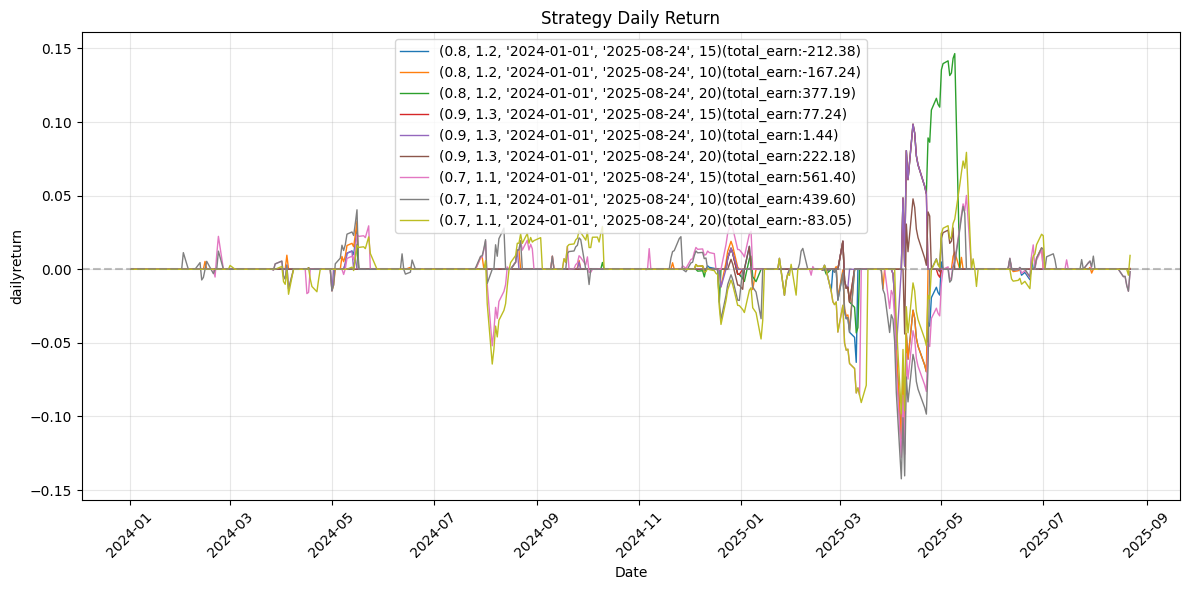

In [8]:
#Key results
strategies = [
    (0.8,1.2,'2024-01-01','2025-08-24',15),
    (0.8,1.2,'2024-01-01','2025-08-24',10),
    (0.8,1.2,'2024-01-01','2025-08-24',20),
    (0.9,1.3,'2024-01-01','2025-08-24',15),
    (0.9,1.3,'2024-01-01','2025-08-24',10),
    (0.9,1.3,'2024-01-01','2025-08-24',20),
    (0.7,1.1,'2024-01-01','2025-08-24',15),
    (0.7,1.1,'2024-01-01','2025-08-24',10),
    (0.7,1.1,'2024-01-01','2025-08-24',20),
]
system_backtest_1(strategies,stock='^GSPC')

In [2]:
import yfinance as yf
from sklearn.linear_model import LinearRegression   
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [3]:
#get stock data
def get_data(stock:str,start,end,interval='1d'):
    """
    获取指定股票在指定时间段内的数据。

    参数:
        stock (str): 股票代码，仅支持一个（如 'AAPL', '600519.SS'）。
        start (str): 起始日期，格式如 '2020-01-01'。
        end (str): 结束日期，格式如 '2024-06-30'。
        interval (str): 数据的时间粒度或频率 "1m", "2m", "5m", "15m", "30m", "60m", "90m", "1h", "1d", "5d", "1wk", "1mo", "3mo"。
    返回:
        DataFrame，包含 Open, Close, Adj Close, High, Low, Volume
    """
    sk_ticker = yf.Ticker(stock) 
    hist = sk_ticker.history(start=start, end=end, interval=interval)
    # df = hist[['Open', 'Close', 'Adj Close', 'High', 'Low', 'Volume']].copy()
    df = hist[['Open', 'Close', 'High', 'Low', 'Volume']].copy()
    return df

In [4]:
#construct factors
def factor_highlow_beta_1(window,data):
    """
    计算滚动窗口内的high-low beta因子
    
    Parameters:
    window: int, 滚动窗口大小
    data: DataFrame, 包含'Open', 'High', 'Low'等列的数据
    
    Returns:
    Series: 每行对应的beta值，但是窗口函数之前的行是NaN
    """
    def get_beta(window_data):
        high = window_data['High'].values.reshape(-1, 1)
        low = window_data['Low'].values
        model = LinearRegression()
        model.fit(high, low)
        return model.coef_[0]
    result = []
    for i in range(len(data)):
        if i<window-1:
            result.append(np.nan)
        else:
            window_data = data.iloc[i-window+1:i+1]
            beta = get_beta(window_data)
            result.append(beta)
    return pd.Series(result,index=data.index)

In [5]:
#backtest for one strategy based on factor 1
def backtest_1(data,long,short):#get the return
    data = data.copy()
    # buy/sell
    data['signal'] = 0
    data['signal'] = np.where(data['beta1']>long,1,data['signal'])
    data['signal'] = np.where(data['beta1']<short,0,data['signal'])
    data['position'] = data['signal'].shift(1)
    data.loc[0,'position'] = 0
    data['daily_r'] = 0.0
    # calculate hold period return
    data['position_diff'] = data['position'].diff()
    buy_points = data[data['position_diff']==1].index.tolist()
    sell_points = data[data['position_diff']==-1].index.tolist()
    trades = []

    for i, buy_idx in enumerate(buy_points):
        buy_price = data.loc[buy_idx, 'Open'] 
        if i < len(sell_points):
            sell_idx = sell_points[i]
            sell_price = data.loc[sell_idx, 'Open']
        else:
            sell_idx = data.index[-1]
            sell_price = data.loc[sell_idx, 'Close']
        earn = sell_price-buy_price
        ret = earn/buy_price
        trades.append(
            {
                'buy_idx':buy_idx,
                'buy_date':data.loc[buy_idx,'Date'],
                'buy_price':buy_price,
                'sell_idx':sell_idx,
                'sell_date':data.loc[sell_idx,'Date'],
                'sell_price':sell_price,
                'earn':earn,
                'return':ret
            }
        )
        #for plot
        holding_period = data.loc[buy_idx:sell_idx]
        for idx in holding_period.index:
            if idx == sell_idx and i>= len(sell_points):
                current_open = data.loc[idx, 'Close']
            else:
                current_open = data.loc[idx, 'Open']
            data.loc[idx, 'daily_r'] = (current_open - buy_price) / buy_price 
    #total earn
    total_earn = sum([trade['earn'] for trade in trades])
    daily_r = data['daily_r'].values
    return total_earn,daily_r
#plot the return
def plot_1(data,results,strategies):
    '''
    results: list, element: (total_earn,daily_r)  
    '''
    plt.figure(figsize=(12,6))
    for i,(total_earn,daily_r) in enumerate(results):
        plt.plot(data['Date'],daily_r,label=f'{strategies[i]}(total_earn:{total_earn:.2f})',linewidth = 1)
    plt.xlabel('Date')
    plt.ylabel('dailyreturn')
    plt.title('Strategy Daily Return')
    plt.legend()
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#backtest the multiple strategies based on factor 1
def system_backtest_1(strategies,stock='^GSPC'):
    ''' 
    data: raw data from get_data
    strategies: list, element: (long,short,start,end,window)
    '''
    results = []
    for i,(long,short,start,end,window) in enumerate(strategies):
        data = get_data(stock=stock,start=start,end=end,interval='1d')
        df = data.copy()
        df.reset_index(inplace=True)
        df['Date'] = pd.to_datetime(df['Date']).dt.date
        df['beta1'] = factor_highlow_beta_1(window,df)
        total_earn,daily_r = backtest_1(df,long,short)
        results.append((total_earn,daily_r))
    plot_1(df,results,strategies)

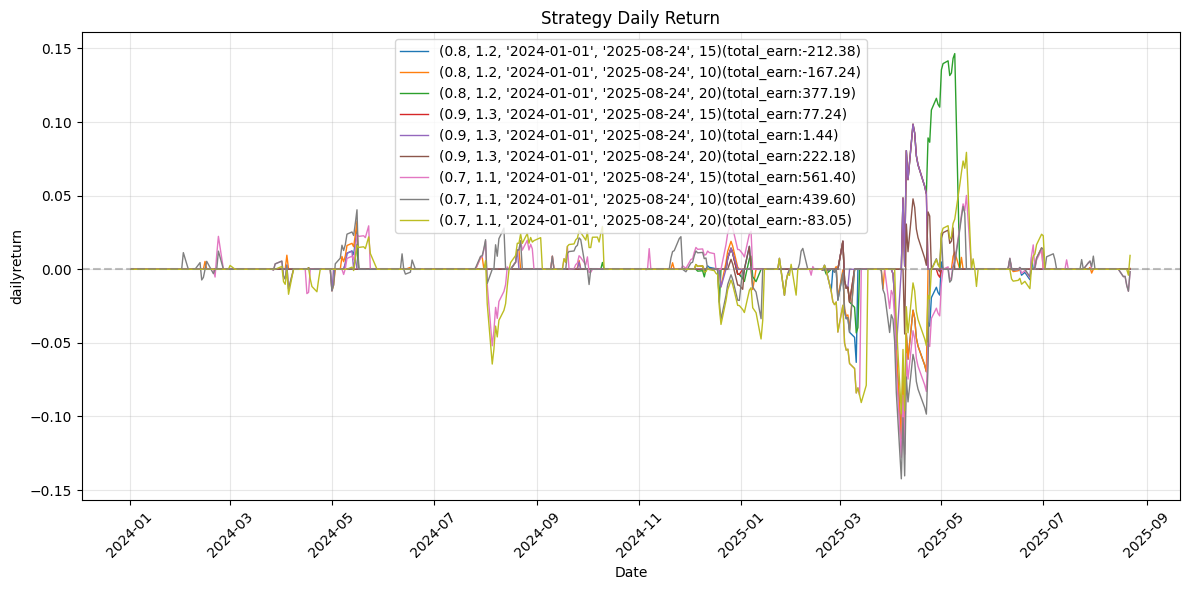

In [6]:
#example
strategies = [
    (0.8,1.2,'2024-01-01','2025-08-24',15),
    (0.8,1.2,'2024-01-01','2025-08-24',10),
    (0.8,1.2,'2024-01-01','2025-08-24',20),
    (0.9,1.3,'2024-01-01','2025-08-24',15),
    (0.9,1.3,'2024-01-01','2025-08-24',10),
    (0.9,1.3,'2024-01-01','2025-08-24',20),
    (0.7,1.1,'2024-01-01','2025-08-24',15),
    (0.7,1.1,'2024-01-01','2025-08-24',10),
    (0.7,1.1,'2024-01-01','2025-08-24',20),
]
system_backtest_1(strategies,stock='^GSPC')

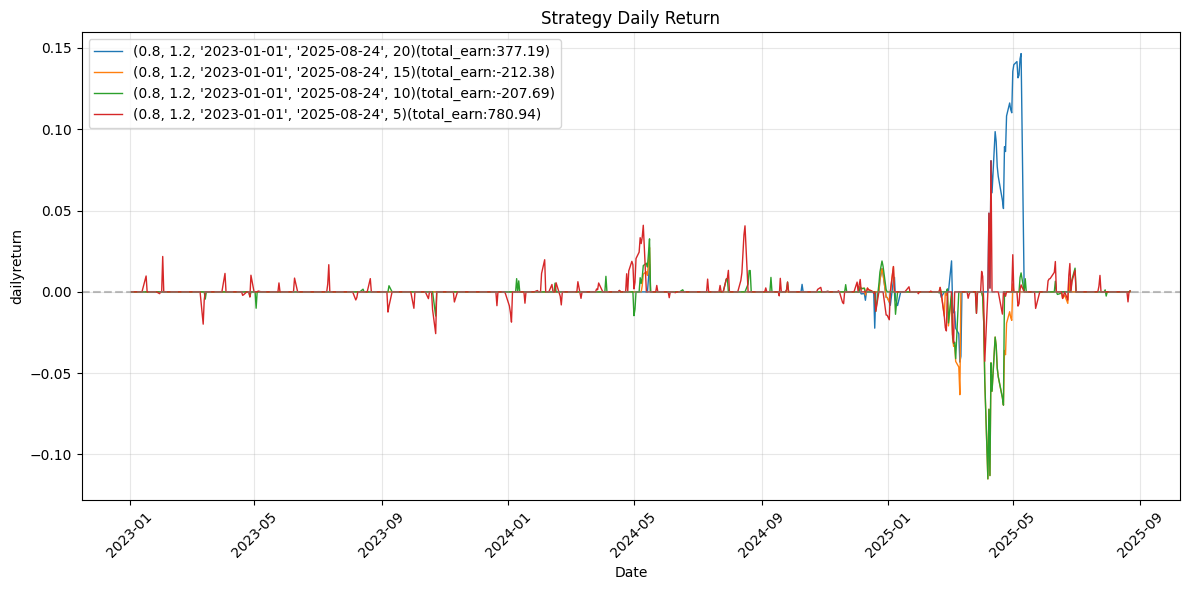

In [7]:
#example
strategies = [
    (0.8,1.2,'2023-01-01','2025-08-24',20),
    (0.8,1.2,'2023-01-01','2025-08-24',15),
    (0.8,1.2,'2023-01-01','2025-08-24',10),
    (0.8,1.2,'2023-01-01','2025-08-24',5)
]
system_backtest_1(strategies,stock='^GSPC')

Text(0, 0.5, 'Open Price')

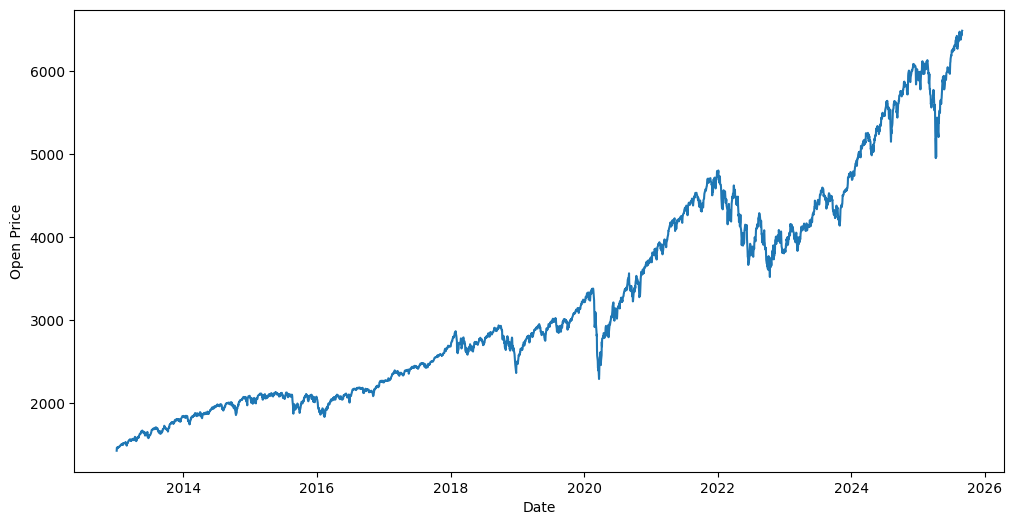

In [9]:
a = yf.Ticker('^GSPC').history(start='2013-01-01', end='2025-08-31', interval='1d')
a.reset_index(inplace=True)
a['Date'] = pd.to_datetime(a['Date']).dt.date
y = a['Open'].values
x = a['Date'].values 
plt.figure(figsize=(12,6))
plt.plot(x,y)
plt.xlabel('Date')  
plt.ylabel('Open Price')

Text(0, 0.5, 'Open Price')

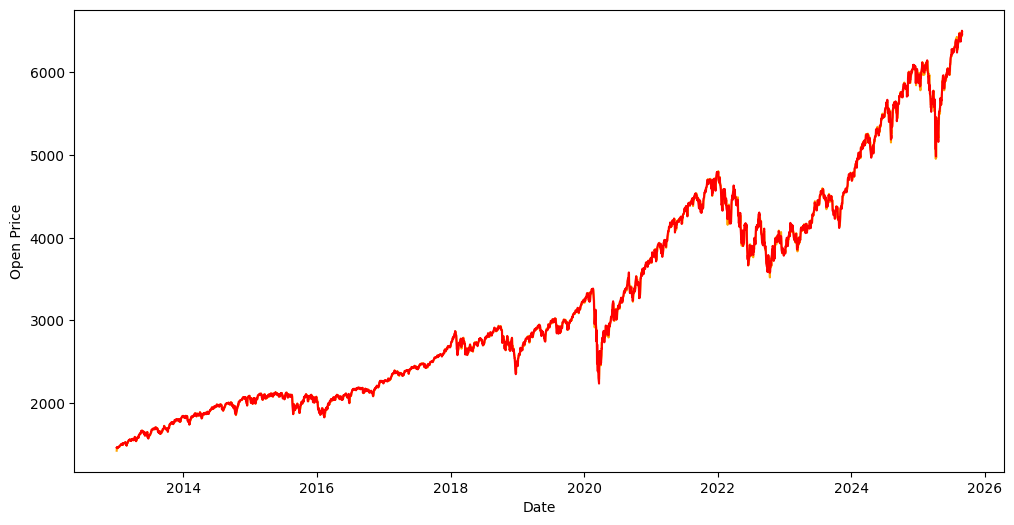

In [19]:

y = a['Open'].values
y1 = a['Close'].values
plt.figure(figsize=(12,6))
plt.plot(x,y,color='orange',label='Open Price')
plt.plot(x,y1,color='red',label='Close Price')
plt.xlabel('Date')  
plt.ylabel('Open Price')

Text(0, 0.5, 'Diff Price')

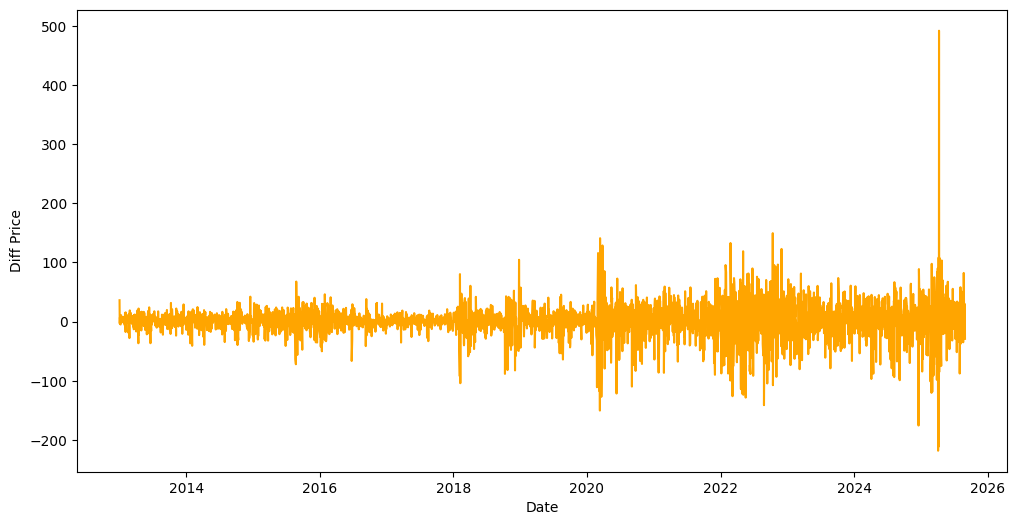

In [14]:
diff = y1-y
plt.figure(figsize=(12,6))
plt.plot(x,diff,color='orange',label='Diff Price')
plt.xlabel('Date')  
plt.ylabel('Diff Price')